# Clickbait spoiling 🖱️
Task description: https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html (task 2)

Data: https://zenodo.org/record/6362726#.YsbdSTVBzrk

In [1]:
import pandas as pd
from transformers import pipeline
from torch.utils.data import DataLoader
import torch.optim as optim

from src.data import read_data, read_spoilers, read_data_classification, save_df_to_jsonl
from src.qa_model import run_qa_model
from src.evaluation import eval_task_2, plot_scores
from src.model_pipelines.bert_classifier import *

## Data preparation

In [2]:
# train = read_data('data/train.jsonl')
# display(train.head())
# train.info()

## Spoiler-type classification
The approach based on [Clickbait Spoiling via Question Answering and Passage Retrieval](https://aclanthology.org/2022.acl-long.484) (Hagen et al., ACL 2022) where firstly a spoiler is classified as "phrase", "passage", "multi" and depending on the classification either QA or PR problem is solved. 

Here, we'll use BERT for the classification part (the classificatin is either `phrase` or `passage` - measing 'passage'/'multi'[multi passage]).

## Fine-Tuning BERT
*TODO (Agata) - ADD TESTS*

In [3]:
MODEL_CHECKPOINT = "bert-base-uncased"

# train_classification = read_data_classification("data/train.jsonl")
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_CHECKPOINT)

# dataset = BertDataset(tokenizer, train_classification)
# dataloader = DataLoader(dataset=dataset, batch_size=32)

# model = BERTClassifier(MODEL_CHECKPOINT)
# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# model = finetune_BERT(10, dataloader, model, loss_fn, optimizer)

In [4]:
# load the model
PATH = "models/bert_classifier.pt"
model = BERTClassifier(MODEL_CHECKPOINT)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
validation_df = read_data("data/validation.jsonl")
validation_df.head(3)

,uuid,title,question,context,context_classification,spoiler,tags
0,6dc7ddef-4e8e-4a6b-9296-526377518071,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy’s Sequel Delayed for Wei...,[some of the plot elements are so disturbing t...,0
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,Why Arizona Sheriff Joe Arpaio’s fate could ha...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"[""intentionally"", could transform a court case...",0
2,8091ba93-6376-473a-9117-01d6cf0507e4,Here’s how much you should be tipping your hai...,Here’s how much you should be tipping your hai...,Here’s how much you should be tipping your hai...,Here’s how much you should be tipping your hai...,[20%],1


In [6]:
# EXAMPLE (1 - "phrase", 0 - "passage"/"multi")
x = 123

text = validation_df.iloc[x]["context_classification"]
tag = validation_df.iloc[x]["tags"]
print(text)

prediction = predict_spoiler_class_from_text(text, model, tokenizer)
print(f'True label: {tag}, predicted label: {prediction}')

This guy went on a holiday with a group of total strangers for the greatest reason For Nathan’s birthday, nine of his friends planned a trip to Majorca. But unfortunately one of them, Joe McGrath, bailed. Instead of having to look at one empty seat all week, the group of friends decided to take matters into their own hands, and find a new Joe McGrath to take with them. One of the group messaged some Joe McGraths on Facebook. He wrote: Would you consider coming on holiday with a group of nine strangers if they had already arranged flights for you and an all inclusive hotel? It’s our friend Nathan’s 30th birthday and we decided to throw him a surprise holiday break in Mallorca. They asked 15 namesakes, but only this one said yes: @GRALambo They asked 15 Joe McGraths and I was the only mad enough Joe to say yes!!! So this happened pic.twitter.com/99MQXdZVyw McGrath wrote on Facebook that he doubted the legitimacy of the offer at first. He wrote: Although I had my doubt if the offer was le

## Question Answering model
Firstly, we will verify existing approach - question answering pipeline with roberta-base-squad2 model.

In [5]:
qa_pipeline = pipeline(model="deepset/roberta-base-squad2")

Downloading:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

### Verify sample spoilers and assess accuracy
For now, simply check if real and generated spoiler intersect with at least one word.

In [20]:
score = []
preds = dict({"uuid" : [],
             "spoiler": []})

print("correct | generated spoiler | true spoiler")
for i, uuid, question, context, spoiler in zip(range(10), train.uuid, train.question, train.context, train.spoiler):
    answer = qa_pipeline(
        question=question,
        context=context,
    )
    if any(word in spoiler[0].split() for word in answer['answer'].split()):
        score.append(1)
    else:
        score.append(0)
    print(score[i], answer['answer'], spoiler)
    preds["uuid"].append(uuid)
    preds["spoiler"].append(answer['answer'])

pred_df = pd.DataFrame.from_dict(preds)
print(f"\nAccuracy: {sum(score)/len(score)}")

correct | generated spoiler | true spoiler
1 let’s go throw ['how about that morning we go throw?']
1 2070 ['2070']
0 money ['intellectual stimulation']
0 Adopting a peripheral perspective ['Purpose connects us to something bigger and in doing so makes us right sized', 'be ruthless with your "No’s."', 'Practice means greatness is doable ... one tiny step after another', 'planning of the SMART goal and number-crunching variety', 'Objectivity — the ability to see the world as it truly is']
0 I follow these steps ['in a rice cooker']
1 you'll have to buy new ones ["Apple says that if AirPods are lost or stolen, you'll have to buy new ones, just like any other Apple product."]
0 Is he constantly hungover ['"The more good games I had in them, the more I got used to them.']
1 -10 degrees Celsius," said Hänninen. ['rainbow colours in the sky and a halo spanning 360 degrees']
0 5/5 say yes ['Red wine is clearly the drink of choice if you are doing light to moderate drinking for your health, a

There is definitely room for improvement, some generated spoiler are perfectly correct, but some are totally missed.

## Evaluation
We will use script provided by SemEval23 organizers to evaluate our approaches. The scripts takes data in the form of JSONL file with columns `uuid` and `spoiler`.

The modules calculates two scores:
1. [BLEU](https://pl.wikipedia.org/wiki/BLEU): Quality is considered to be the correspondence between a machine's output and that of a human, the higher the better. The score takes values between 0 and 1.
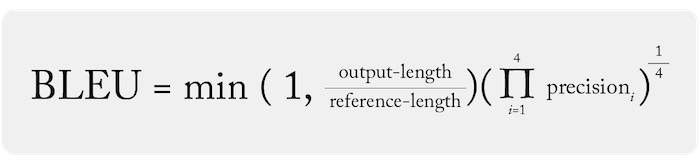
2. [BERT](https://github.com/Tiiiger/bert_score): Leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. The range is -1 to 1.
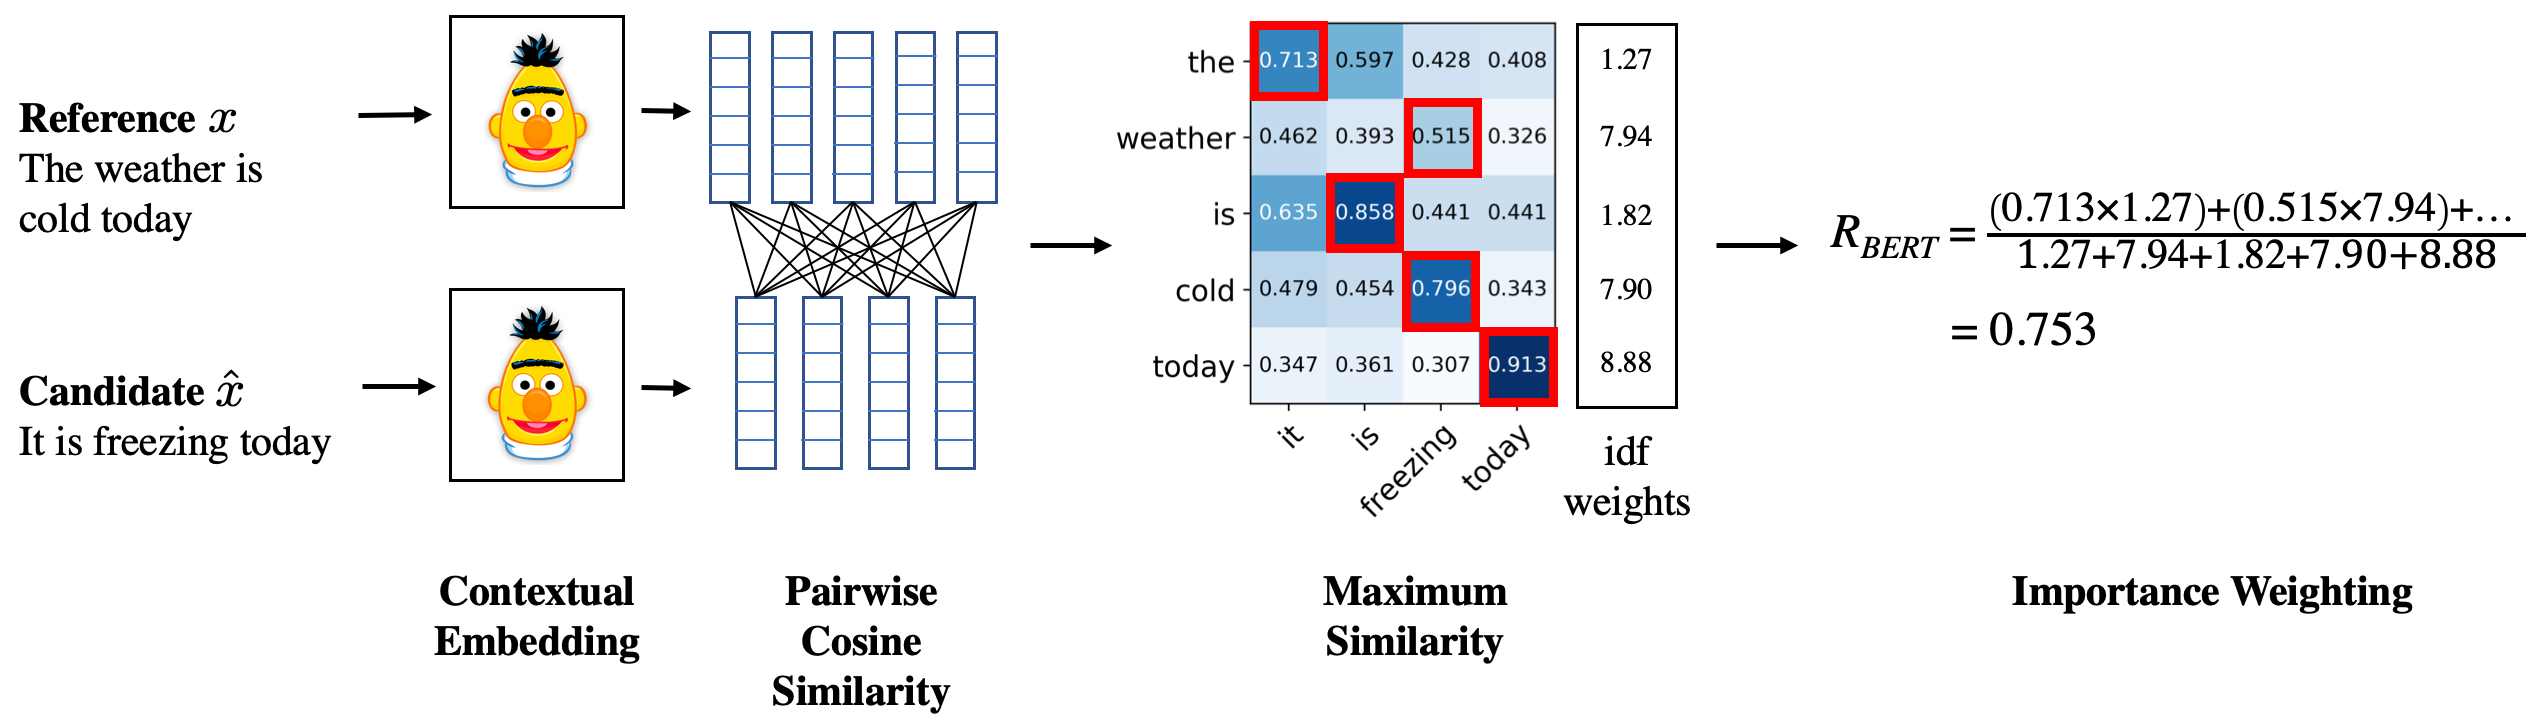

In [21]:
save_df_to_jsonl(train.iloc[:10], "data/test_true.jsonl")
save_df_to_jsonl(pred_df, "data/test_output.jsonl")

In [ ]:
scores = eval_task_2("data/test_output.jsonl", "data/test_true.jsonl")

In [11]:
print(scores)

measure{
  key: "result-size-all-spoilers"
  value: "3200"
}
measure{
  key: "bleu-score-all-spoilers"
  value: "0.25914445523695245"
}
measure{
  key: "bert-score-all-spoilers"
  value: "0.8715313076972961"
}
measure{
  key: "missing-predictions-all-spoilers"
  value: "0"
}


## RoBERTa
Question answering taking spoiler type into account.

In [2]:
run_qa_model("data/validation.jsonl", "data/preds.jsonl")

Using GPU for pipeline
Using GPU for pipeline


  1%|▏         | 10/800 [00:03<02:44,  4.80it/s]/home/zuzg/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 800/800 [02:39<00:00,  5.03it/s]


In [ ]:
scores = eval_task_2("data/preds.jsonl", "data/validation.jsonl")

In [3]:
scores

{'result-size-all-spoilers': 800,
 'bleu-score-all-spoilers': 0.2833054912141546,
 'bert-score-all-spoilers': 0.8829432129859924,
 'missing-predictions-all-spoilers': 0,
 'result-size-phrase-spoilers': 335,
 'bleu-score-phrase-spoilers': 0.4776299651420253,
 'bert-score-phrase-spoilers': 0.9287846088409424,
 'missing-predictions-phrase-spoilers': 0,
 'result-size-passage-spoilers': 322,
 'bleu-score-passage-spoilers': 0.1800982175291465,
 'bert-score-passage-spoilers': 0.8525652289390564,
 'missing-predictions-passage-spoilers': 0,
 'result-size-multi-spoilers': 143,
 'bleu-score-multi-spoilers': 0.06046663359692279,
 'bert-score-multi-spoilers': 0.8439561128616333,
 'missing-predictions-multi-spoilers': 0}

/home/zuzg/nlp/clickbait-spoiling/src/evaluation.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


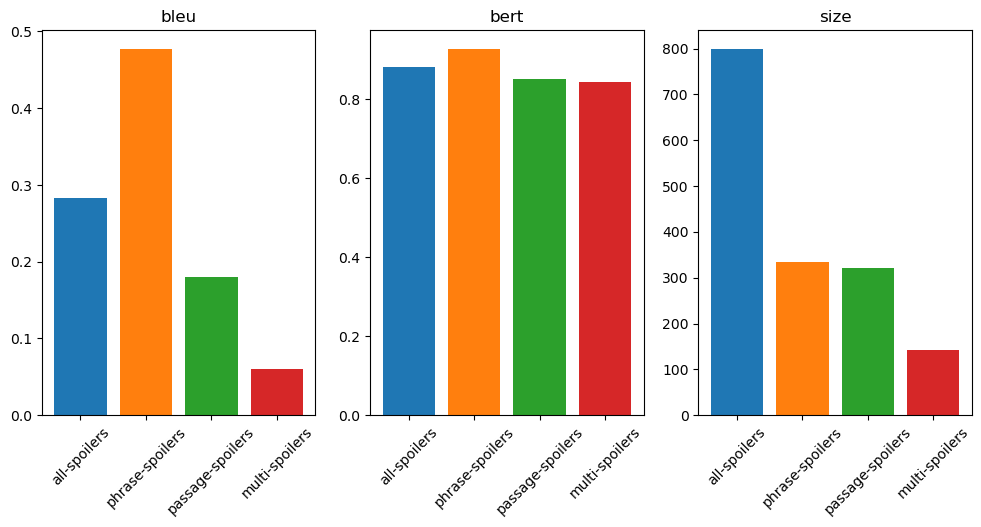

In [4]:
plot_scores(scores)

### Sample predictions

In [4]:
val = read_spoilers("data/validation.jsonl")
pd.set_option('display.max_colwidth', None)
val.head(10)

,uuid,spoiler
0,6dc7ddef-4e8e-4a6b-9296-526377518071,[some of the plot elements are so disturbing that they are making him feel sick]
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,"[""intentionally"", could transform a court case against Phoenix-area Sheriff Joe Arpaio from civil charges to a criminal prosecution]"
2,8091ba93-6376-473a-9117-01d6cf0507e4,[20%]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,"[Alan Rickman & Rupert Grint, CBGB]"
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,[a man who swallowed a 64GB microSD card and then pooped it into a strainer]
5,804ba7e2-2e3b-439b-9ee4-6827939c902d,[Sprite]
6,d636e94d-d27a-4366-b177-1299c266d7b5,[Smoky Paprika-Baked Garbanzo Beans]
7,cf3cb892-fb30-4210-a525-e5e7aa921082,"[McGonagall was appointed as Dumbledore’s assistant in 1956, not as his replacement.]"
8,a86850fc-047b-432b-bc85-5e198ff4527f,[All the scenes are actually in the movie]
9,ba35ffbc-1eba-4940-8c68-00eefecd2178,"[""I had fake relationships, fake fights. I don't care anymore, I can tell you.]"


In [5]:
pred = read_spoilers("data/preds.jsonl")
pred.head(10)

,uuid,spoiler
0,6dc7ddef-4e8e-4a6b-9296-526377518071,"[According to a post by Cawthon on the Five Nights at Freddy’s: Sister Location Steam page, the game is being delayed because it’s too dark]"
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,"[intentionally, """", criminal prosecution, , ]"
2,8091ba93-6376-473a-9117-01d6cf0507e4,[slightly smaller tip]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,"[Michael Gambon, Newcastle accent, Julie Walters, Alan, chocolate]"
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,"[The story is written in the first person by ""John Doe,"" who is apparently embarrassed by the incident and chose to remain anonymous]"
5,804ba7e2-2e3b-439b-9ee4-6827939c902d,[Sprite]
6,d636e94d-d27a-4366-b177-1299c266d7b5,[midnight]
7,cf3cb892-fb30-4210-a525-e5e7aa921082,[]
8,a86850fc-047b-432b-bc85-5e198ff4527f,"[The filmmaker was directly asked if fans can expect to see a post-credits scene or Easter Egg at the end of the sequel, and he quickly dismissed the idea, saying: ""No, there’s not]"
9,ba35ffbc-1eba-4940-8c68-00eefecd2178,"[""I had fake relationships, fake fights]"
